# Project: Advanced Lane Finding

## Imports

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Camera Calibration

Build a class which will handle the camera calibration and further undistortion.

In [2]:
import os

class FolderContent:
    def __init__(self, folder):
        self.content = [folder+'/'+img_name for img_name in os.listdir(folder)]
        
def get_file_name(path):
    return path[path.index('/')+1:]

# Calibrate the camera.
class CameraCalibration:
    def __init__(self, grid_shape, calibration_folder):
        '''
        Ctor.
        params: 
        grid_shape: tuple with the shape of the grid
        calibration_folder: folder with the images to be used for calibration.
        '''
        self.grid_shape = grid_shape

        # Prepare object points. We'll be using the 9x6 calibration chessboard.
        
        self.calibration_folder = calibration_folder
        self.calibrate()
        
    def calibrate(self):
        """
        Calibrates the camera.
        """
        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3D points in real space
        imgpoints = [] # 2D points in image plane 
        
        m = self.grid_shape[0]
        n = self.grid_shape[1]
        objp = np.zeros((n*m,3), np.float32)
        objp[:,:2] = np.mgrid[0:m,0:n].T.reshape(-1,2) # x, y coordinates
        
        # prepare the list of image names to be used for calibration.
        calibration_images = FolderContent(self.calibration_folder).content

        # image shape to be used for calibration
        shape = 0

        for image_path in calibration_images:
            # read image
            img = cv2.imread(image_path)

            # convert to grayscale image to be used for finding the corners
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # obtain the shape of an image
            if shape == 0:
                shape = gray.shape[::-1]

            # find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

            if ret:
                # append corners and object points if everything is fine.
                imgpoints.append(corners)
                objpoints.append(objp)

        # calibrate the camera and return camera matrix and distortion coefficients.
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
        
        self.mtx = mtx
        self.dist = dist
        self.rvecs = rvecs
        self.tvecs = tvecs
    
    def undistort(self, img):
        """
        Undistort the image, based on the calibration results.
        Params:
        img - the distorted image.
        Returns: undistored image.
        """
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        

# The shape of calibration grid.
grid_shape = (9,6)
        
# Images for calibration.
calibration_folder = 'camera_cal'

# Create an instance of CameraCalibration to be used later.
camera = CameraCalibration(grid_shape, calibration_folder)


Let's test the defined class below. In order to do so, I will run the method undistort on every distorted image from the folder 'camera_cal' and draw the distorted-undistorted image pairs for comparison. All the undistorted images will be saved to the folder 'camera_cal_undistorted'.

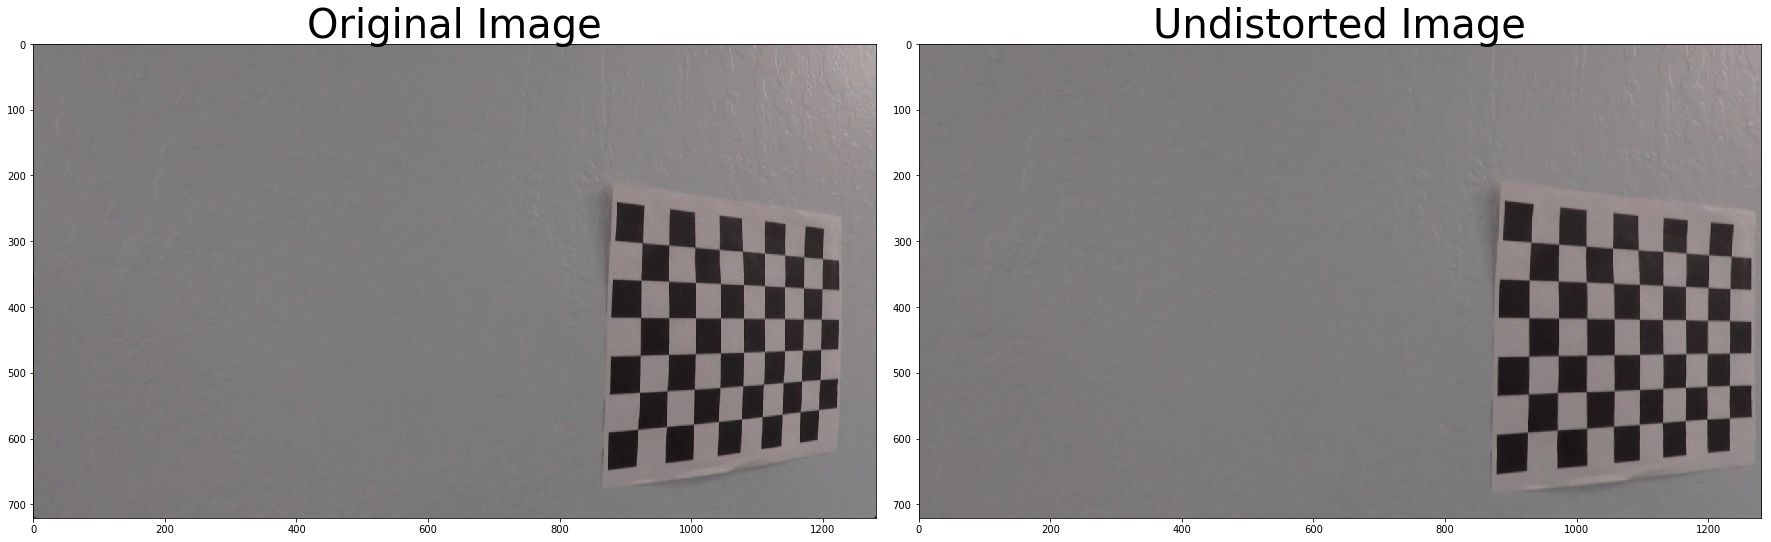

In [3]:
# Folder where to save the undistorted images.
undistorted_folder = 'camera_cal_undistorted'

# Populate the images for undistortion.
img_names = FolderContent(calibration_folder).content

# Prepare 2 images (original and undistorted).
img = cv2.imread(img_names[0])
undistorted = camera.undistort(img)

# Prepare the figure for plotting.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Process all images and write the results to 'camera_cal_undistorted' folder.
for img_name in img_names:
    img = cv2.imread(img_name)
    undistorted = camera.undistort(img)
    undistorted_name = undistorted_folder + '/' + get_file_name(img_name)
    cv2.imwrite(undistorted_name, undistorted)


## Creating a binary image containing likely lane pixels

In order to create a binary image, containing likely lane pixels I implemnted a method apply_threshold which does the following:
1. Converts an image in BGR color space to HLS and retrieve the H, L, S channels. The S channel in HLS preserves pretty much of the shape given different lighting conditions. We need the rest of the channels to separate yellow and white lines from other shapes on the road.
2. Apply Sobel X and Y filters to S and L channels.
3. Threshold X and Y gradients on S and L channel (I used threshold values (50, 200)).
4. Threshold H, L, S channels to identify white and yellow colors:
    - yellow - H (0,85), L (120,255), S (75,255)
    - white - H (20,255), L (170,255), S (0,80)
5. Combined binaries from thresholds which gives a pretty accurate lane lines.

Please see the source code and figures below.

In [105]:
# Import toolset for widgets.
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

test_images_folder = 'test_images'
test_images_names = FolderContent(test_images_folder).content

test_image_name = test_images_names[0]


# The pipeline to build the binary image containing likely lane pixels.
def apply_threshold(img, wh_thresh = (20,255), wl_thresh = (170,255), ws_thresh = (0,80), 
                    yh_thresh = (0,85), yl_thresh = (120,255), ys_thresh = (75,255), sx_thresh=(50, 200)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # white
    wh_binary = np.zeros_like(h_channel)
    wh_binary[(h_channel > wh_thresh[0]) & (h_channel <= wh_thresh[1])] = 1
    
    wl_binary = np.zeros_like(l_channel)
    wl_binary[(l_channel > wl_thresh[0]) & (l_channel <= wl_thresh[1])] = 1
    
    ws_binary = np.zeros_like(s_channel)
    ws_binary[(s_channel > ws_thresh[0]) & (s_channel <= ws_thresh[1])] = 1
    
    
    # yellow
    yh_binary = np.zeros_like(h_channel)
    yh_binary[(h_channel > yh_thresh[0]) & (h_channel <= yh_thresh[1])] = 1
    
    yl_binary = np.zeros_like(l_channel)
    yl_binary[(l_channel > yl_thresh[0]) & (l_channel <= yl_thresh[1])] = 1
    
    ys_binary = np.zeros_like(s_channel)
    ys_binary[(s_channel > ys_thresh[0]) & (s_channel <= ys_thresh[1])] = 1
    
    # Sobel x on S channel
    sobelx_s = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx_s = np.absolute(sobelx_s) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_xs = np.uint8(255*abs_sobelx_s/np.max(abs_sobelx_s))
    
    # Sobel y on S channel
    sobely_s = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1)
    abs_sobely_s = np.absolute(sobely_s)
    scaled_sobel_ys = np.uint8(255*abs_sobely_s/np.max(abs_sobely_s))
    
    # Sobel x on L channel
    sobelx_l = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx_l = np.absolute(sobelx_l) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_xl = np.uint8(255*abs_sobelx_l/np.max(abs_sobelx_l))
    
    # Sobel y on L channel
    sobely_l = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
    abs_sobely_l = np.absolute(sobely_l)
    scaled_sobel_yl = np.uint8(255*abs_sobely_s/np.max(abs_sobely_l))
    
    # Threshold x gradient
    xbinary = np.zeros_like(scaled_sobel_xs)
    xbinary[((scaled_sobel_xs >= sx_thresh[0]) & (scaled_sobel_xs <= sx_thresh[1])) |
             ((scaled_sobel_xl >= sx_thresh[0]) & (scaled_sobel_xl <= sx_thresh[1]))] = 1
    
    # Threshold x gradient
    ybinary = np.zeros_like(scaled_sobel_ys)
    ybinary[((scaled_sobel_ys >= sx_thresh[0]) & (scaled_sobel_ys <= sx_thresh[1])) |
             ((scaled_sobel_yl >= sx_thresh[0]) & (scaled_sobel_yl <= sx_thresh[1]))] = 1
        
    s_binary = np.zeros_like(s_channel)
    s_binary[(xbinary==1) & (ybinary==1)] = 1
    
    # Combine binaries
    combined_binary = np.zeros_like(xbinary)
    #combined_binary[(s_binary==1) | ((wh1_binary == 1) & (ws1_binary == 1) & (wv_binary == 1)) | ((yh1_binary == 1) & (ys1_binary == 1) & (yv_binary == 1))] = 1
    #combined_binary[(s_binary == 1) | (sxbinary==1)] = 1
    combined_binary[(s_binary == 1) | ((wh_binary == 1) & (ws_binary == 1) & (wl_binary == 1)) | ((yh_binary == 1) & (ys_binary == 1) & (yl_binary == 1))] = 1 # 
    
    # Apply low pass filter to get rid of noise.
    #kernel = np.ones((9,9),np.float32)/81
    #thresholded_image = cv2.filter2D(combined_binary,-1,kernel)
    thresholded_image = combined_binary
    
    return thresholded_image


# Method to apply widget.
def test_threshold(wh_low, wh_high, wl_low, wl_high, ws_low, ws_high, yh_low, yh_high, yl_low, yl_high, ys_low, ys_high, sx_low, sx_high):
    # Read the first test image just for testing purposes.
    img = cv2.imread(test_image_name)
    
    # Undistort it.
    image_undistorted = camera.undistort(img)

    # Apply the color thresholding pipeline.
    thresholded_image = apply_threshold(image_undistorted, (wh_low, wh_high), (wl_low, wl_high), (ws_low, ws_high), (yh_low, yh_high), (yl_low, yl_high), (ys_low, ys_high), (sx_low, sx_high))

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax1.imshow(image_rgb)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(thresholded_image)
    ax2.set_title('Threshold Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

interact(test_threshold, wh_low=(0,255), wh_high=(0,255), wl_low=(0,255), wl_high=(0,255), ws_low=(0,255), ws_high=(0,255), yh_low=(0,255), yh_high=(0,255), yl_low=(0,255), yl_high=(0,255), ys_low=(0,255), ys_high=(0,255),  sx_low=(0,255), sx_high=(0,255))

# Read the first test image just for testing purposes.
image = cv2.imread(test_image_name)

# Undistort it.
image_undistorted = camera.undistort(image)

# Apply the color thresholding pipeline.
thresholded_image = apply_threshold(image_undistorted)


interactive(children=(IntSlider(value=127, description='wh_low', max=255), IntSlider(value=127, description='wh_high', max=255), IntSlider(value=127, description='wl_low', max=255), IntSlider(value=127, description='wl_high', max=255), IntSlider(value=127, description='ws_low', max=255), IntSlider(value=127, description='ws_high', max=255), IntSlider(value=127, description='yh_low', max=255), IntSlider(value=127, description='yh_high', max=255), IntSlider(value=127, description='yl_low', max=255), IntSlider(value=127, description='yl_high', max=255), IntSlider(value=127, description='ys_low', max=255), IntSlider(value=127, description='ys_high', max=255), IntSlider(value=127, description='sx_low', max=255), IntSlider(value=127, description='sx_high', max=255), Output()), _dom_classes=('widget-interact',))

Just for the needs of report - drawing the original and an undistorted image.

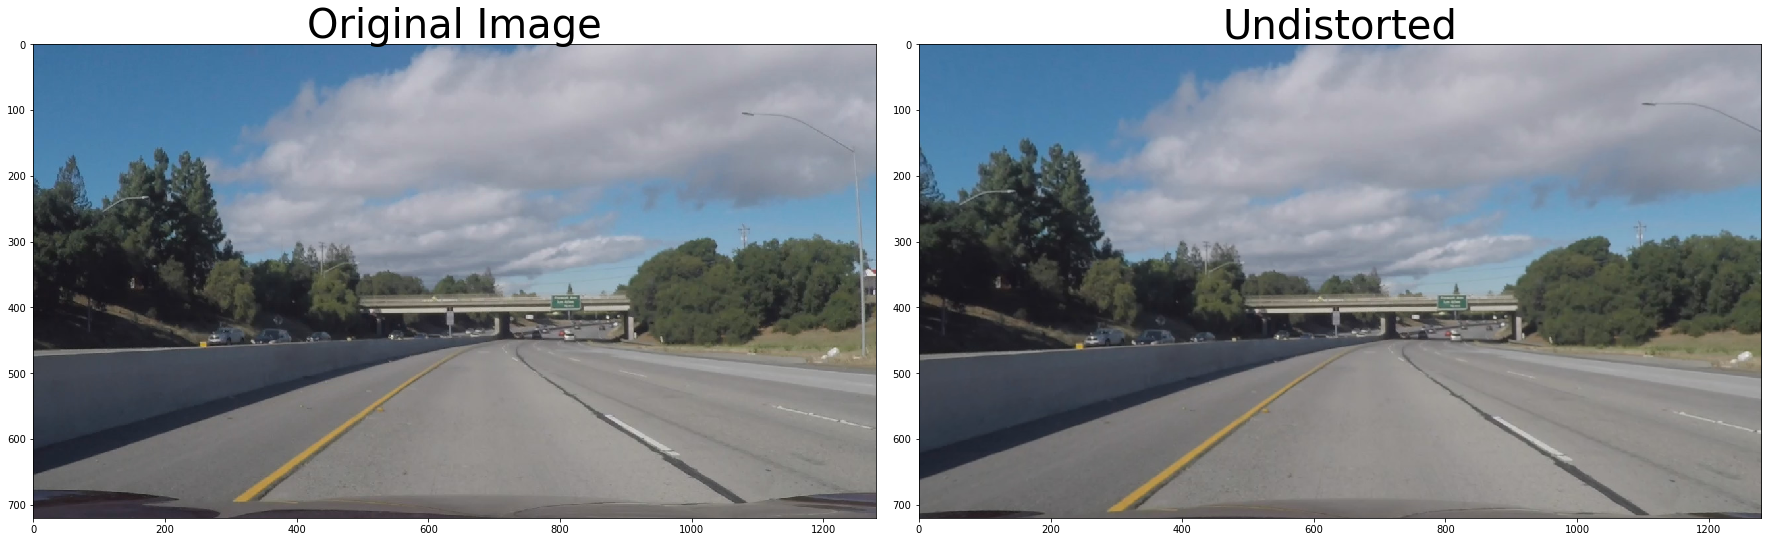

In [5]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax1.imshow(image_rgb)
ax1.set_title('Original Image', fontsize=40)

undistorted_rgb = cv2.cvtColor(image_undistorted, cv2.COLOR_BGR2RGB)
ax2.imshow(undistorted_rgb)
ax2.set_title('Undistorted', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Now it's time to process all the images from test_images folder to get the binary image. The resulting images are available in the 'binary_images' folder. The process is as follows: read image, undistort, apply threshold.

In [6]:
# Process all test images to get the corresponding binary image.
binary_output = 'binary_images'

for img_name in test_images_names:
    print(img_name)
    if img_name[len(img_name)-4:] == ".jpg":
        img = cv2.imread(img_name)
        undistorted = camera.undistort(img)
        binary = apply_threshold(undistorted)
        binary_name = binary_output + '/' + get_file_name(img_name)
        cv2.imwrite(binary_name, binary)

test_images/test1.jpg
test_images/project_video1.jpg
test_images/test5.jpg
test_images/straight_lines1.jpg
test_images/straight_lines2.jpg
test_images/.ipynb_checkpoints
test_images/test3.jpg
test_images/test4.jpg
test_images/challenge_video1.jpg
test_images/test6.jpg
test_images/challenge_video2.jpg
test_images/project_video2.jpg
test_images/test2.jpg


## Apply the Perspective Transform to convert the images to birds eye view

Now it's time to adjust the pipeline, so it uses the Perspective Transform to convert the images to birds eye view. This is needed to further process an image in order to find the lane lines. The transformation can be done as follows:
- define the corresponding points on source and destination images to calculate the transformation matrix.
- calculate the transformation matrix using cv2.getPerspectiveTransform
- apply the transformation by using cv2.warpPerspective

The examples of original and transformed images are shown below as well as the source code implementation of the above steps.

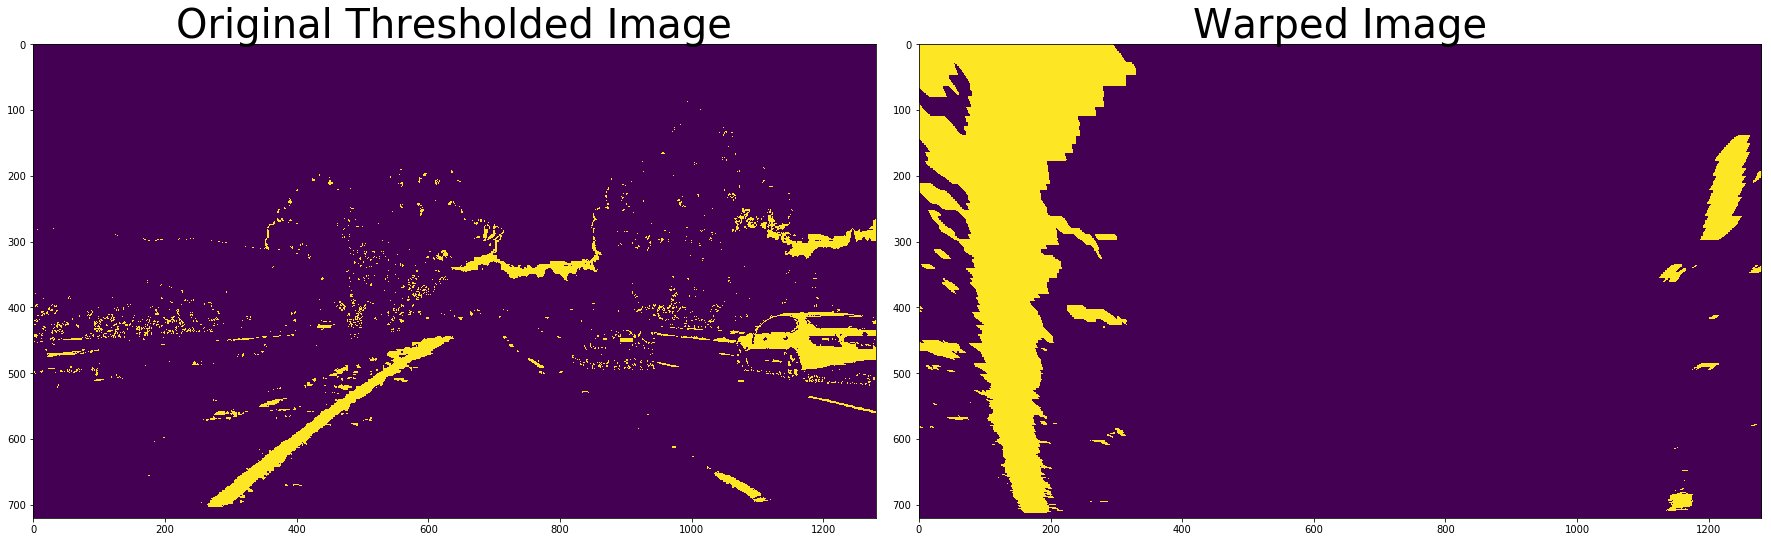

In [106]:
# Define the source and destination points.
def apply_perspective_transform(img):
    # Define the image size.
    img_size = (img.shape[1], img.shape[0])

    offset = 100
    
    # Define the source and destination points to be used to find the transformation matrix.
    src = np.float32([[1.8*img_size[0]/6,img_size[1]], [2.85*img_size[0]/6,1.95*img_size[1]/3], [3.4*img_size[0]/6,1.95*img_size[1]/3], [img_size[0]-offset,img_size[1]]])
    dst = np.float32([[1.5*img_size[0]/6,img_size[1]], [1.5*img_size[0]/6,0], [img_size[0]-offset,0], [img_size[0]-offset,img_size[1]]])
    
    
    # Retrieve the transformation matrix.
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Retrieve the inversed transformation matrix.
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Apply Perspective Transform.
    warped = cv2.warpPerspective(img, M, img_size)
    
    # Return transformed image.
    return warped, M, Minv

warped, _, _ = apply_perspective_transform(thresholded_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(thresholded_image)
ax1.set_title('Original Thresholded Image', fontsize=40)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Fit the lane lines with polynomials

Next we are going to fit the lane lines with polynomials. In order to do so we need to follow these steps:
- Create a histogram of the bottom half of the image to actually find the points where to start searching for a lane lines. The lane lines starting points can be easily identified as the peaks on in the left and right parts of histogram (1 on each side).

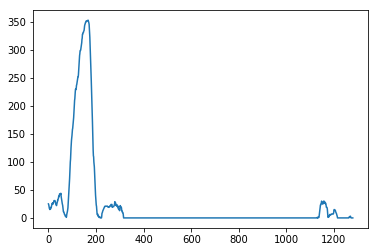

In [107]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    imgshape = (img.shape[1], img.shape[0])
    yhalf = int(imgshape[1]/2)
    bottom_half = img[yhalf:,:]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

histogram = hist(warped)
plt.plot(histogram)

- Use the sliding window to fit lane lines polynomials having the starting points identified form a histogram. The resulting binary warped image with lane lines identified is shown below as well as the source code to achieve that.

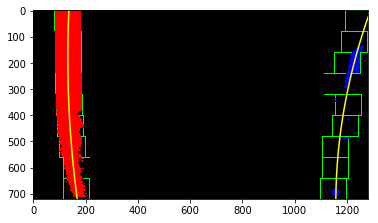

In [108]:
# Define conversions in x and y from pixels space to meters
def get_meters_per_pix(img_shape):
    ym_per_pix = 30/img_shape[1] # meters per pixel in y dimension
    xm_per_pix = 3.7/img_shape[0] # meters per pixel in x dimension
    
    return ym_per_pix, xm_per_pix

def find_lane_pixels(binary_warped, draw_rectangles=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image if needed
        if draw_rectangles:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) 
                & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) 
                & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, draw_rectangles=False, draw_lines=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, draw_rectangles)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    if draw_lines:
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

out_img, left_fit, right_fit = fit_polynomial(warped, True, True)

plt.imshow(out_img)


- If we have the polynomial coefficients from the previous frame, we should go with an attempt to find lane lines based on these polynomials and margin.

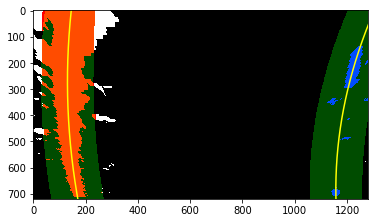

In [109]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix, xm_per_pix = get_meters_per_pix(img_shape)
    
    left_fitreal = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fitreal = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, left_fitreal, right_fitreal


# Define hyperparameters
line_fit_thresh = 5
coefficients_diff = .01
smoothing_coefficients = {'old':.95, 'new':.05}

def search_around_poly(binary_warped, left_fit_orig, right_fit_orig, margin=100, draw_lines=False):
    correctly_found = True
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > np.polyval(left_fit_orig, nonzeroy) - margin) 
                        & (nonzerox < np.polyval(left_fit_orig, nonzeroy) + margin))
    right_lane_inds = ((nonzerox > np.polyval(right_fit_orig, nonzeroy) - margin) 
                        & (nonzerox < np.polyval(right_fit_orig, nonzeroy) + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit, left_fitreal, right_fitreal = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    left_diff = np.max(np.abs(left_fit-left_fit_orig))
    
    right_diff = np.max(np.abs(right_fit-right_fit_orig))
    
    if (len(leftx) <= line_fit_thresh) or (left_diff > coefficients_diff):
        left_fit = left_fit_orig
        correctly_found = False
        
    if (len(rightx) <= line_fit_thresh) or (right_diff > coefficients_diff):
        right_fit = right_fit_orig
        correctly_found = False
        
    left_fit = smoothing_coefficients['old']*left_fit_orig + smoothing_coefficients['new']*left_fit
    right_fit = smoothing_coefficients['old']*right_fit_orig + smoothing_coefficients['new']*right_fit
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if draw_lines:
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
    
    return result, left_fit, right_fit, correctly_found

# Run image through the pipeline
result, _, _, _ = search_around_poly(warped, left_fit, right_fit, 100, True)

# View your output
plt.imshow(result)

## Radius of curvature of the lane and the position of the vehicle with respect to center

To calculate the radius of curvature of the lane and the position of the vehicle with respect to center I did the following:

In [110]:
def measure_curvature(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # The calculation of R_curve (radius of curvature)
    y = y_eval
    left_curverad = ((1+(2*left_fit_cr[0]*y+left_fit_cr[1])**2)**(3/2))/np.abs(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_cr[0]*y+right_fit_cr[1])**2)**(3/2))/np.abs(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

def measure_image_curvature(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    imgshape = (binary_warped.shape[1], binary_warped.shape[0])
    
    ym_per_pix, xm_per_pix = get_meters_per_pix(imgshape)

    # Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])*ym_per_pix
    
    return measure_curvature(ploty, left_fit, right_fit)

def get_distance_from_center(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    imgshape = (binary_warped.shape[1], binary_warped.shape[0])
    
    ym_per_pix, xm_per_pix = get_meters_per_pix(imgshape)
    
    # Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])*ym_per_pix
    y = np.max(ploty)
    
    image_center = (imgshape[0]/2)*xm_per_pix
    left_lane_pos = np.polyval(left_fit, y)
    right_lane_pos = np.polyval(right_fit, y)
    
    offset = (left_lane_pos+right_lane_pos)/2 - image_center
    
    return offset

left_curverad, right_curverad = measure_image_curvature(warped)
lane_curverad = (left_curverad + right_curverad)/2
print ("Lane curvature = {} m.".format(lane_curverad))

distance_from_lane_center = get_distance_from_center(warped)
print ("The distance from the center of the lane is {} m.".format(distance_from_lane_center))
    

Lane curvature = 1835.4242096358391 m.
The distance from the center of the lane is 0.06513593262590645 m.


## Putting the things together

Now it's time to combine what was achieved so far into a single pipeline which identifies the lane lines in a single image and finds the lane curvature and the distance from the car to the center of the lane.

Let's implement the pipeline to process single image. It will contain the following steps:
- Preprocess image: undistort, apply color threshold and apply the perspective transform.
- Find lane lines, by finding the grade 2 polynomial coefficients corresponding to the lane lines.
- Calculate lane curvature and position of the car in relation to the center of the lane.
- Draw the polygon occupying the area between the identified lane lines.
- Combine the original image and the empty image with lane lines drawn.
- Write a text on the resulting image telling the info about lane curvature and distance from the center of the lane.

test_images/test1.jpg


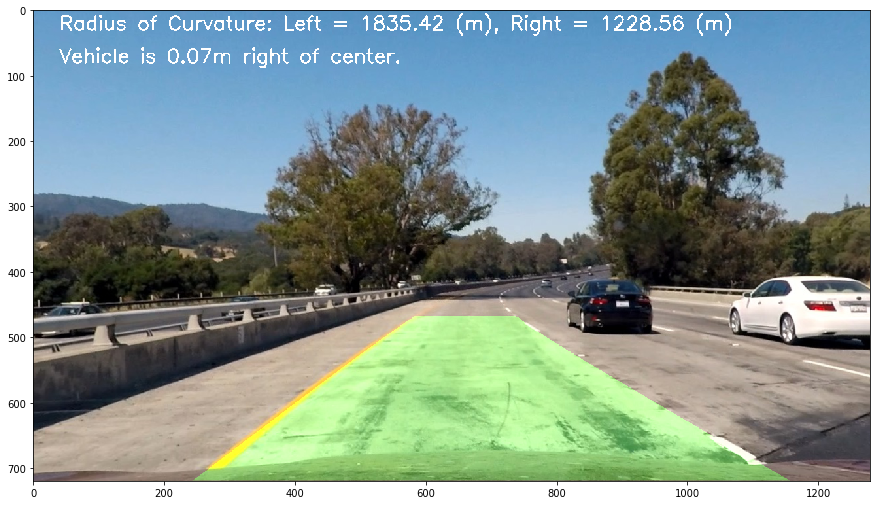

In [111]:
def preprocess_image(img, camera):
    # Undistort.
    undistorted = camera.undistort(img)
    
    # Apply the color thresholding pipeline.
    thresholded_image = apply_threshold(undistorted)
    
    # Apply perspective transform.
    warped, M, Minv = apply_perspective_transform(thresholded_image)
    
    return undistorted, warped, M, Minv

def create_empty_image_for_drawing(warped):
    # Create an image to draw a lines on.
    warped_zero = np.zeros_like(warped)
    color_warp = np.dstack((warped_zero, warped_zero, warped_zero))
    
    return color_warp

def get_lane_curvature(warped):
    # Measure the image curvature.
    left_curverad, right_curverad = measure_image_curvature(warped)
    lane_curverad = (left_curverad + right_curverad)/2
    
    return lane_curverad, left_curverad, right_curverad

def draw_lane_lines_on_empty_image(original_img_shape, warped, left_fit, right_fit, Minv):
    color_warp = create_empty_image_for_drawing(warped)
    
    # Generate x and y values for plotting.
    ploty = np.linspace(0, original_img_shape[0]-1, original_img_shape[0])
    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)
    
    # Prepare the points to fill in the area in between the lane lines.
    pts_left = np.vstack((left_fitx,ploty)).astype(np.int32).T
    pts_right = np.vstack((right_fitx,ploty)).astype(np.int32).T
    pts_right = np.flipud(pts_right) # keep the points going in a clockwise fashion from the endpoints of the lines.
    points = np.concatenate((pts_left, pts_right))
    
    # Fill in the area between the lane lines.
    cv2.fillPoly(color_warp, [points], (0,255,0))
    
    # Transform the image with polygon back to the real size.
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    
    return newwarp, ploty, left_fitx, right_fitx

def draw_text_data(img, left_curverad, right_curverad, distance_from_lane_center):
    # Draw the corresponding texts on an image.
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    
    position = 'left' if distance_from_lane_center < 0 else 'right'
    
    cv2.putText(img, "Radius of Curvature: Left = {:.2f} (m), Right = {:.2f} (m)".format(lane_curverad, right_curverad), (40, 30), font, fontScale, fontColor, lineType)
    cv2.putText(img, "Vehicle is {:.2f}m {} of center.".format(np.abs(distance_from_lane_center), position), (40, 80), font, fontScale, fontColor, lineType)


def process_single_image(img, camera):
    
    # Do the image pre-processing: undistort, apply perspective transform and return transformation matrices.
    undistorted, warped, M, Minv = preprocess_image(img, camera)
    
    # Find lane lines and return the polynomial coefficients.
    _, left_fit, right_fit = fit_polynomial(warped)
    
    # Measure the image curvature.
    lane_curverad, left_curverad, right_curverad = get_lane_curvature(warped)
    
    # Measure the distance from lane center.
    distance_from_lane_center = get_distance_from_center(warped)
    
    # Prepare the output image
    out_img = undistorted#cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
    
    # Draw the lane lines on an empty image
    newwarp, _, _, _ = draw_lane_lines_on_empty_image(out_img.shape, warped, left_fit, right_fit, Minv)
    
    # Draw the radius of curvature and the distance form the center of the lane
    draw_text_data(out_img, left_curverad, right_curverad, distance_from_lane_center)
        
    # Combine the resulting image with the filled lane lines.
    result = cv2.addWeighted(out_img, 1, newwarp, 0.3, 0)
    
    return result


test_image_name = test_images_names[0]

print (test_image_name)

test_image = cv2.imread(test_image_name)
out_img = process_single_image(test_image, camera)

out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

plt.clf()
plt.figure(figsize=(15,10))
plt.imshow(out_img)
    

Now it's time to process all the test images. The results can be found in the 'output_images' folder.

In [13]:
output_folder = 'output_images'

# Iterate through all the images in test folder and draw the lane lines in there.
for test_image_name in test_images_names:
    if test_image_name[len(test_image_name)-4:] == ".jpg":
        test_image = cv2.imread(test_image_name)
        print (test_image_name)
        out_img = process_single_image(test_image, camera)
        
        out_img_name = output_folder + '/' + get_file_name(test_image_name)
        cv2.imwrite(out_img_name, out_img)
    

test_images/test1.jpg
test_images/project_video1.jpg
test_images/test5.jpg
test_images/straight_lines1.jpg
test_images/straight_lines2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/challenge_video1.jpg
test_images/test6.jpg
test_images/challenge_video2.jpg
test_images/project_video2.jpg
test_images/test2.jpg


## Pipeline for processing the video stream

It's time to combine this alltogether and implement the pipeline for video stream processing.

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # is it the first frame?
        self.first_frame = True
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = [] 
        # number of bad frames in a row
        self.bad_frames = 0

In [99]:
number_of_fits = 10
number_of_bad_frames = 10

def draw_lane_lines_on_empty_image(original_img_shape, warped, ploty, left_fitx, right_fitx, Minv):
    color_warp = create_empty_image_for_drawing(warped)
    
    # Prepare the points to fill in the area in between the lane lines.
    pts_left = np.vstack((left_fitx,ploty)).astype(np.int32).T
    pts_right = np.vstack((right_fitx,ploty)).astype(np.int32).T
    pts_right = np.flipud(pts_right) # keep the points going in a clockwise fashion from the endpoints of the lines.
    points = np.concatenate((pts_left, pts_right))
    
    # Fill in the area between the lane lines.
    cv2.fillPoly(color_warp, [points], (0,255,0))
    
    # Transform the image with polygon back to the real size.
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    
    return newwarp
    
def process_image(image, camera, line):
    # Do the image pre-processing: undistort, apply perspective transform and return transformation matrices.
    undistorted, imgwarped, M, Minv = preprocess_image(image, camera)
    
    # Prepare the output image
    output_image = undistorted#cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
    
    # Find lane lines and return the polynomial coefficients.
    try:
        
        lines_correctly_found = True
        
        if line.first_frame:
            line.first_frame = False
            _, left_fit, right_fit = fit_polynomial(imgwarped)
            
            # Smoothen the coefficients
            if len(line.best_fit) > 0:
                left_fit_orig, right_fit_orig = line.best_fit
            
                # Workout the bad lanes
                left_diff = np.max(np.abs(left_fit-left_fit_orig))

                right_diff = np.max(np.abs(right_fit-right_fit_orig))

                if left_diff > coefficients_diff:
                    left_fit = left_fit_orig
                    line.first_frame = True

                if right_diff > coefficients_diff:
                    right_fit = right_fit_orig
                    line.first_frame = True
                
                left_fit = smoothing_coefficients['old']*left_fit_orig + smoothing_coefficients['new']*left_fit
                right_fit = smoothing_coefficients['old']*right_fit_orig + smoothing_coefficients['new']*right_fit
        else:
            _, left_fit, right_fit, lines_correctly_found = search_around_poly(imgwarped, line.best_fit[0], line.best_fit[1])
            
        # Measure the image curvature.
        _, left_curverad, right_curverad = get_lane_curvature(imgwarped)

        # Measure the distance from lane center.
        distance_from_lane_center = get_distance_from_center(imgwarped)
            
        line.current_fit.append(np.array([left_fit, right_fit]))

        line.radius_of_curvature = (left_curverad, right_curverad) 
        line.line_base_pos = distance_from_lane_center 

        line.best_fit = line.current_fit[-1]
        
        # Generate x and y values for plotting.
        ploty = np.linspace(0, output_image.shape[0]-1, output_image.shape[0])
        left_fitx = np.polyval(left_fit, ploty)
        right_fitx = np.polyval(right_fit, ploty)

        line.ally.append(ploty)
        line.allx.append(np.array([left_fitx, right_fitx]))

        line.bestx = line.allx[-1]
        
        # Work out the incorrectly found lines
        if not lines_correctly_found:
            line.bad_frames += 1
            
            #print (line.bad_frames)
            
            if line.bad_frames >= number_of_bad_frames:
                
                #print ("doing a reset")
                # Do a reset
                line.first_frame = True
                line.bad_frames = 0
                line.current_fit = []
            
    except:
           left_fit, right_fit = line.best_fit 
    
    
    
    # Draw the lane lines on an empty image
    newwarp = draw_lane_lines_on_empty_image(output_image.shape, imgwarped, line.ally[-1], line.bestx[0], line.bestx[1], Minv)
    
    # Draw the radius of curvature and the distance form the center of the lane
    draw_text_data(output_image, line.radius_of_curvature[0], line.radius_of_curvature[1], line.line_base_pos)
        
    # Combine the resulting image with the filled lane lines.
    result = cv2.addWeighted(output_image, 1, newwarp, 0.3, 0)
    
    return result




In [86]:
project_video_output = 'project_video_processed.mp4'
line = Line()
def process_video_frame(image):
    result = process_image(image, camera, line)#process_image(image, camera, line)
    return result
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")

project_video_clip = clip1.fl_image(process_video_frame) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4



 24%|██▍       | 303/1261 [01:52<05:58,  2.67it/s]


 48%|████▊     | 605/1261 [03:51<04:27,  2.45it/s]


 72%|███████▏  | 907/1261 [05:45<02:15,  2.62it/s]


 96%|█████████▌| 1205/1261 [07:44<00:21,  2.62it/s]


100%|█████████▉| 1260/1261 [08:05<00:00,  2.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 4min 29s, sys: 1min 26s, total: 5min 56s
Wall time: 8min 8s


In [87]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

In [103]:
challenge_video_output = 'challenge_video_processed.mp4'
line = Line()
def process_video_frame(image):
    result = process_image(image, camera, line)#process_image(image, camera, line)
    return result
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip("challenge_video.mp4")

challenge_video_clip = clip2.fl_image(process_video_frame) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_processed.mp4
[MoviePy] Writing video challenge_video_processed.mp4


  3%|▎         | 16/485 [00:04<02:08,  3.66it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly conditioned



  5%|▍         | 23/485 [00:06<02:07,  3.62it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 10%|█         | 49/485 [00:14<02:36,  2.78it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly conditioned



 10%|█         | 50/485 [00:14<02:32,  2.85it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly conditioned



 11%|█         | 51/485 [00:15<02:39,  2.73it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly conditioned






 21%|██        | 102/485 [00:32<02:12,  2.90it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned


 22%|██▏       | 106/485 [00:34<02:10,  2.90it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 22%|██▏       | 108/485 [00:35<02:13,  2.82it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 23%|██▎       | 110/485 [00:35<02:12,  2.83it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 23%|██▎ 

 44%|████▍     | 214/485 [01:16<01:40,  2.70it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned


 46%|████▌     | 221/485 [01:18<01:30,  2.91it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly conditioned



 46%|████▌     | 222/485 [01:19<01:34,  2.78it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly conditioned



 46%|████▌     | 223/485 [01:19<01:31,  2.85it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly conditioned



 47%|████▋     | 226/485 [01:20<01:29,  2.88it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 51%|█████     | 246/485 [01:27<01:23,  2.85it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly conditioned



 52%|█████▏    | 251/485 [01:29<01:19,  2.95it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned


 52%|█████▏    | 254/485 [01:30<01:16,  3.00it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 57%|█████▋    | 277/485 [01:38<01:11,  2.92it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly conditioned



 58%|█████▊    | 280/485 [01:39<01:10,  2.91it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly condition

 72%|███████▏  | 347/485 [02:02<00:46,  3.00it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 72%|███████▏  | 349/485 [02:02<00:46,  2.95it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 73%|███████▎  | 352/485 [02:03<00:46,  2.89it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 74%|███████▎  | 357/485 [02:05<00:42,  2.98it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is sep

  



 80%|████████  | 390/485 [02:17<00:31,  2.97it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 81%|████████  | 392/485 [02:17<00:32,  2.85it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 84%|████████▍ | 407/485 [02:22<00:26,  2.94it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until

  



 84%|████████▍ | 408/485 [02:23<00:27,  2.82it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RankWarning: Polyfit may be poorly conditioned



 85

[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_processed.mp4 

CPU times: user 1min 35s, sys: 28.6 s, total: 2min 4s
Wall time: 2min 53s


In [104]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

The pipeline coded above consists of the following steps (you can review the results in 'project_video_processed.mp4' and 'challenge_video_processed.mp4'):

- Preprocess image: undistort, apply color threshold and apply the perspective transform.
- Find lane lines, by finding the grade 2 polynomial coefficients corresponding to the lane lines.
    - If it's the first frame, or after the number of unsuccessful frames, use histogram to find the starting position for sliding window to find the lane lines.
    - If the previous frame was successfully processed, use the averaged polynomial coefficients for several previous frames to look around these lines +- margin.
        - Run sanity check and do the smoothing
            - Sanity check: if the coefficients differ by the value .1, grab the previous coefficients, say that the lane lines were not found the way they should and work out this way.
            - Smoothing: in order to smooth the lane lines on the video I was getting the new coefficients which are the result of the following summation: .95 * old_coeff + .05 * new_coeff
- Calculate lane curvature and position of the car in relation to the center of the lane.
- Draw the polygon occupying the area between the identified lane lines.
- Combine the original image and the empty image with lane lines drawn.
- Draw a text on the resulting image telling the info about lane curvature and distance from the center of the lane.


So, my pipeline for the video processing does a good job on the main project video file and does an average job on challenge video file. The thresholding technique can be improved to work better under different lighting conditions (it works well for most of the cases though).
However, if the curvature of the lane line frequently changes on large values, it wouldn't work well as the sanity check combined with smooting technique will prevent it from drawing the accurate lane lines.
In order to make a good progress with finding any lane lines, it's worth considering to use the machine learning techniques, e.g. semantic segmentation which may give the opportunity to actually build the robust solution to accurately find and smoothen the lane lines. I plan to work towards this in my spare time to actually get this up and running.